In [263]:
import os
import pandas as pd
import numpy as np
from scipy.signal import hilbert, convolve
import matplotlib.pyplot as plt
import json

def load_sync_file(mouse_org_data_path,mouse):
    current_animals_behav_sync_path = os.path.join(mouse_org_data_path, r"behav_sync\\")
    for stage in os.listdir(current_animals_behav_sync_path):
        if 'post' in stage:
            sync_path = current_animals_behav_sync_path + stage + '\\'
    if mouse == '148_2_2':
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv', encoding='cp1252')
    else:
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv')
        
    return sync_df 

def load_in_sleep_state_scoring(mouse):
    print('---------------------')
    print('searching for sleep state scoring')
    # determine organised data paths for the current mouse
    if mouse.split('_')[0].isdigit():
        org_dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
        old_data = True
    else:
        org_dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
        old_data = False
    org_mouse_file = None
    for file in os.listdir(org_dat_path):
        if mouse.split('_')[0] in file:
            # if the implant = implant
            if mouse.split('_')[1] == file.split('_')[-1][-1]:
                print(f'1. mouse file found: \033[1m{file}\033[0m')
                org_mouse_file = os.path.join(org_dat_path,file)
    mouse_org_data_path = None
    for recording in os.listdir(org_mouse_file):
        if mouse.split('_')[-1] == recording.split('_')[0].split('recording')[-1]:
            print(f'2. recording found: \033[1m{recording}\033[0m')
            mouse_org_data_path = os.path.join(org_mouse_file,recording) + r'\\'

    # load in sleep scoring data 
    try:
        sleep_state_score_path = mouse_org_data_path + r"\ephys\ProbeA\LFP\\sleep_state_score\\"
        nrem_start_ends = np.load(sleep_state_score_path + "nrem_start_ends.npy", allow_pickle=True)
        rem_start_ends = np.load(sleep_state_score_path + "rem_start_ends.npy", allow_pickle=True)
        print (f"\033[1mSuccess!\033[0m Loaded sleep state score files for mouse: {mouse}.")
    except:
        print('Fail: not found using first path type...')
    try:
        sleep_state_score_path = mouse_org_data_path + r"\ephys\ProbeA\LFP\\"
        nrem_start_ends = np.load(sleep_state_score_path + "nrem_start_ends.npy", allow_pickle=True)
        rem_start_ends = np.load(sleep_state_score_path + "rem_start_ends.npy", allow_pickle=True)
        print (f"\033[1mSuccess!\033[0m Loaded sleep state score files for mouse: {mouse}.")
    except:
        print(f"Sleep state score files not found for {mouse}.")

    print('----------------------')
        
    return nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data


def filter_for_spindles_and_plot(spindle_bandpassed,nrem_intervals,rem_intervals,fs,min_event_duration,sleep_period_ephys_start_time):

    time = np.arange(len(spindle_bandpassed)) / fs
    # adjust time to account for trimmed down ephys lfp
    time += sleep_period_ephys_start_time

    # Compute the smoothed envelope
    smoothed_envelope = compute_smoothed_envelope(spindle_bandpassed, fs)

    ## filter for NREM sleep times only and find mean and s-dev
    nrem_envelope_perioids = []
    for interval in nrem_intervals:
        nrem_envelope_perioids += list(smoothed_envelope[(time > interval[0]) * (time < interval[1])])
    mean_ = np.mean(nrem_envelope_perioids)
    std_ = np.std(nrem_envelope_perioids)

    upper_threshold = mean_ + 2*std_
    lower_threshold = mean_ + 1*std_

    # Plotting the original signal and the smoothed envelope
    fig, [ax,ax2] = plt.subplots(2, 1,figsize=(20, 10))
    ax.plot(time, spindle_bandpassed, color='b')
    ax.plot(time, smoothed_envelope, label='Smoothed Envelope', color='r')
    ax.axhline(upper_threshold,color = 'c')
    ax.axhline(lower_threshold,color = 'c')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(sleep_period_ephys_start_time+100,sleep_period_ephys_start_time+120)
    ax.set_ylim((-1*upper_threshold)-(0.6*upper_threshold),upper_threshold +(0.6*upper_threshold))

    ## filter for spindles

    offset = sleep_period_ephys_start_time
    spindle_events = find_events(smoothed_envelope,lower_threshold, upper_threshold,fs,min_event_duration,offset)

    ax2.plot(time, spindle_bandpassed, color='b')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Amplitude')

    for event in spindle_events:
        ax2.axvspan(event['start_time'],event['end_time'], alpha=0.5, color='red')
        
    ax2.set_ylim((-1*upper_threshold)-(1.5*upper_threshold),upper_threshold +(1.5*upper_threshold))


    # Add shaded regions without repeating labels
    for ind, (start, end) in enumerate(rem_intervals):
        label = 'rem' if ind == 0 else None
        ax2.axvspan(start, end, color='yellow', alpha=0.2, label=label)

    for ind, (start, end) in enumerate(nrem_intervals):
        label = 'nrem' if ind == 0 else None
        ax2.axvspan(start, end, color='green', alpha=0.2, label=label)

    ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
    
    return spindle_events,smoothed_envelope

def compute_smoothed_envelope(signal, sampling_rate, window_length_ms=200):
    # Convert window length from milliseconds to samples
    window_length_samples = int(window_length_ms * sampling_rate / 1000)
    
    # Compute the analytic signal using Hilbert transform
    analytic_signal = hilbert(signal)
    
    # Compute the magnitude of the analytic signal
    magnitude = np.abs(analytic_signal)
    
    # Create a Gaussian window with specified length
    gaussian_window = np.exp(-0.5 * (np.arange(-window_length_samples, window_length_samples+1) / (0.001 * sampling_rate))**2)
    
    # Normalize the Gaussian window
    gaussian_window /= np.sum(gaussian_window)
    
    # Convolve the magnitude with the Gaussian window
    smoothed_envelope = convolve(magnitude, gaussian_window, mode='same')
    
    return smoothed_envelope

def find_events(signal_data, lower_threshold, upper_threshold, sampling_rate,time_filter,offset):
    events = []
    event_start = None
    peak_magnitude = None
    sum_magnitude = 0
    count_samples = 0

    for i, sample in enumerate(signal_data):
        # Check if the signal crosses the lower threshold
        if sample > lower_threshold:
            if event_start is None:
                event_start = i

            # Check if the signal crosses the upper threshold within the event window
            if sample > upper_threshold:
                peak_magnitude = max(signal_data[event_start:i + 1])
                sum_magnitude += sample
                count_samples += 1

        else:
            # If the event window duration is at least the time filter (s * sampling_rate)
            if event_start is not None and (i - event_start) >= (time_filter * sampling_rate):
                if peak_magnitude is not None and peak_magnitude > upper_threshold:
                    average_magnitude = sum_magnitude / count_samples
                    events.append({
                        "start_time": (event_start / sampling_rate)+offset,
                        "end_time": (i / sampling_rate)+offset,
                        "peak_magnitude": peak_magnitude,
                        'magnitude': sum_magnitude,
                        "average_magnitude": average_magnitude,
                    })

            # Reset event variables
            event_start = None
            peak_magnitude = None
            sum_magnitude = 0
            count_samples = 0

    return events

def load_in_replay_data(mouse,dat_path,nrem_start_ends,rem_start_ends):
    
    print('---------------------')
    print('searching for replay data')

    pp_path = 'SKIP'
    for file in os.listdir(dat_path):
        if mouse == file.split('_run')[0]:
            print(f'file found: \033[1m{file}\033[0m')
            pp_path = os.path.join(dat_path,file)

    if pp_path == 'SKIP':
        return None,'SKIP'
    
    replay_data_path = pp_path + r'\_final_analysis_output\\'

    params_file = pp_path + r'\trainingData\\' + 'params_' + mouse + '.json'
    with open(params_file, 'r') as file:
        params = json.load(file)
    time_spans = params['time_span']

    replay_events_df = pd.DataFrame({})
    start_offset = []
    for file in os.listdir(replay_data_path):
        if 'chunk' in file:
            print(file)

            chunk_number = int(file.split('_')[0][-1])

            start_offs = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
            start_offset +=[start_offs]

            print(replay_data_path)
            df_load = pd.read_csv(replay_data_path + file + r'\filtered_replay_clusters_df.csv',index_col=0)
            
            ## filter this data for sequential ordering
            sequential_condition = df_load.ordering_classification == 'sequential'
            # filter is set up so that any true will carry forward 
            filtered_chunk_data = df_load[sequential_condition].reset_index()
            ## REM / NREM times only
            # get relevant rem/nrem times for chunk
            chunk_time = np.load(replay_data_path + file + '\chunk_time_interval.npy')
            chunk_nrem_times = get_chunk_state_times(nrem_start_ends,chunk_time)
            chunk_rem_times = get_chunk_state_times(rem_start_ends,chunk_time) 
            # get spike times relative to chunk:
            chunk_number = int(file.split('_')[0][-1])
            chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
            # make relative to start of chunk
            fs_event_times = filtered_chunk_data['first_spike_time'].values - chunk_start_offset
            # find inds of spike times that are in nrem and rem periods:
            idx  = []
            for start,end in chunk_nrem_times + chunk_rem_times:
                idx += list(np.where((fs_event_times >= start) & (fs_event_times <= end))[0])
            # filter the data frame, only keeping the rows in idx
            filtered_chunk_data = filtered_chunk_data.iloc[idx]
            filtered_chunk_data = filtered_chunk_data.reset_index(drop=True)
            

            filtered_chunk_data['chunk'] = [chunk_number]*len(filtered_chunk_data)
            
            filtered_chunk_data['chunk_time'] = [time_spans[chunk_number-1]]*len(filtered_chunk_data)
            fs_times_ephys_time = (filtered_chunk_data.first_spike_time.values - start_offs)
            filtered_chunk_data['first_spike_ephys_time'] = fs_times_ephys_time
            filtered_chunk_data["replay_abs_time"] = filtered_chunk_data['chunk_time'].values[0][0] + filtered_chunk_data["first_spike_ephys_time"] + filtered_chunk_data["event_length"]/2
            
            replay_events_df = pd.concat((replay_events_df,filtered_chunk_data),axis =0)
            replay_events_df.reset_index(drop = True)
            
            print (f"\033[1mSuccess!\033[0m Loaded replay data files for mouse: {mouse}.")
            print('---------------------')
                
    return replay_events_df,time_spans



def get_chunk_state_times(rem_start_ends,chunk_time):
    chunk_rem_times = []
    for start,end in rem_start_ends:
        if start >= chunk_time[0] and start <= chunk_time[1]:
            start_chunk_rebased = start - chunk_time[0]
            end_chunk_rebased = end - chunk_time[0]
            # expand by 10%
            start_chunk_rebased = start_chunk_rebased * 0.9
            end_chunk_rebased = end_chunk_rebased * 1.1
            # if the end stetches past the end of the chunk then just set it to the end of the chunk
            if end_chunk_rebased > np.diff(chunk_time)[0]:
                end_chunk_rebased = np.diff(chunk_time)[0]
            chunk_rem_times += [[start_chunk_rebased,end_chunk_rebased]]
    return chunk_rem_times


from scipy.stats import zscore

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def phase_randomize(signal):
    n = len(signal)
    # FFT
    fft_vals = np.fft.fft(signal)

    # Preserve magnitude
    mag = np.abs(fft_vals)

    # Random phase, symmetric to ensure real inverse
    random_phases = np.exp(1j * np.random.uniform(0, 2*np.pi, n//2 - 1))
    phase = np.ones(n, dtype=complex)
    phase[1:n//2] = random_phases
    phase[-(n//2)+1:] = np.conj(random_phases[::-1])  # Hermitian symmetry

    # New FFT
    new_fft = mag * phase

    # Inverse FFT
    randomized_signal = np.fft.ifft(new_fft).real
    return randomized_signal

def calculate_cross_correlation(replay_aligned_spndl_spectral_powers, spndl_replay_binned, smoothing_window,num_shuffles=5000):

    chunk_cross_corr_actual = []
    chunk_temporal_shuffle = []
    chunk_phase_shuffle = []
    for i in range(len(spndl_replay_binned)):
        
        signal1 = zscore(convolve_movmean(replay_aligned_spndl_spectral_powers[i], smoothing_window))
        signal2 = zscore(convolve_movmean(spndl_replay_binned[i],smoothing_window))
        # cross-correlation
        cross_corr_actual = np.correlate(signal1, signal2, mode='full')

        # Initialize an array to store shuffled cross-correlation values
        temporal_shuffle = []
        phase_shuffle = []
        # Perform shuffling and calculate cross-correlation for each iteration
        for i in range(num_shuffles):
            # Shuffle one of the signals (you can choose which one to shuffle)
            t_shuffled_signal1 = np.random.permutation(signal1)
            # do a phase randomisation shuffle
            p_shuffled_signal1 = phase_randomize(signal1)
            # Calculate the cross-correlation with the shuffled signal
            temporal_shuffle += [list(np.correlate(t_shuffled_signal1, signal2, mode = 'full'))]
            phase_shuffle += [list(np.correlate(p_shuffled_signal1, signal2, mode = 'full'))]
            
        percntl_99_temporal = np.percentile(temporal_shuffle, 99, axis=0)
        percntl_99_phase = np.percentile(phase_shuffle, 99, axis=0)

        time_lags = np.arange(-len(signal1) + 1, len(signal1))
        
        chunk_cross_corr_actual += [list(cross_corr_actual[(time_lags > -40) * (time_lags < 40)])]
        chunk_temporal_shuffle += [list(percntl_99_temporal[(time_lags > -40) * (time_lags < 40)])]
        chunk_phase_shuffle += [list(percntl_99_phase[(time_lags > -40) * (time_lags < 40)])]

            
    return chunk_cross_corr_actual, chunk_temporal_shuffle,chunk_phase_shuffle

# main

seq006_1_3
ripples found
---------------------
searching for sleep state scoring
1. mouse file found: seq006_implant1
2. recording found: recording3_18-11-2024
Fail: not found using first path type...
Success! Loaded sleep state score files for mouse: seq006_1_3.
----------------------
spindle events not found - processing...
---------------------
searching for replay data
file found: seq006_1_3_run_0908025_1017
chunk1_10600to11100
Z:\projects\sequence_squad\ppseq_finalised_publication_data\dual_str_hpc\striatum\postsleep\\seq006_1_3_run_0908025_1017\_final_analysis_output\\
Success! Loaded replay data files for mouse: seq006_1_3.
---------------------
chunk2_13700to14000
Z:\projects\sequence_squad\ppseq_finalised_publication_data\dual_str_hpc\striatum\postsleep\\seq006_1_3_run_0908025_1017\_final_analysis_output\\
Success! Loaded replay data files for mouse: seq006_1_3.
---------------------
chunk3_15600to16000
Z:\projects\sequence_squad\ppseq_finalised_publication_data\dual_str_hpc\s

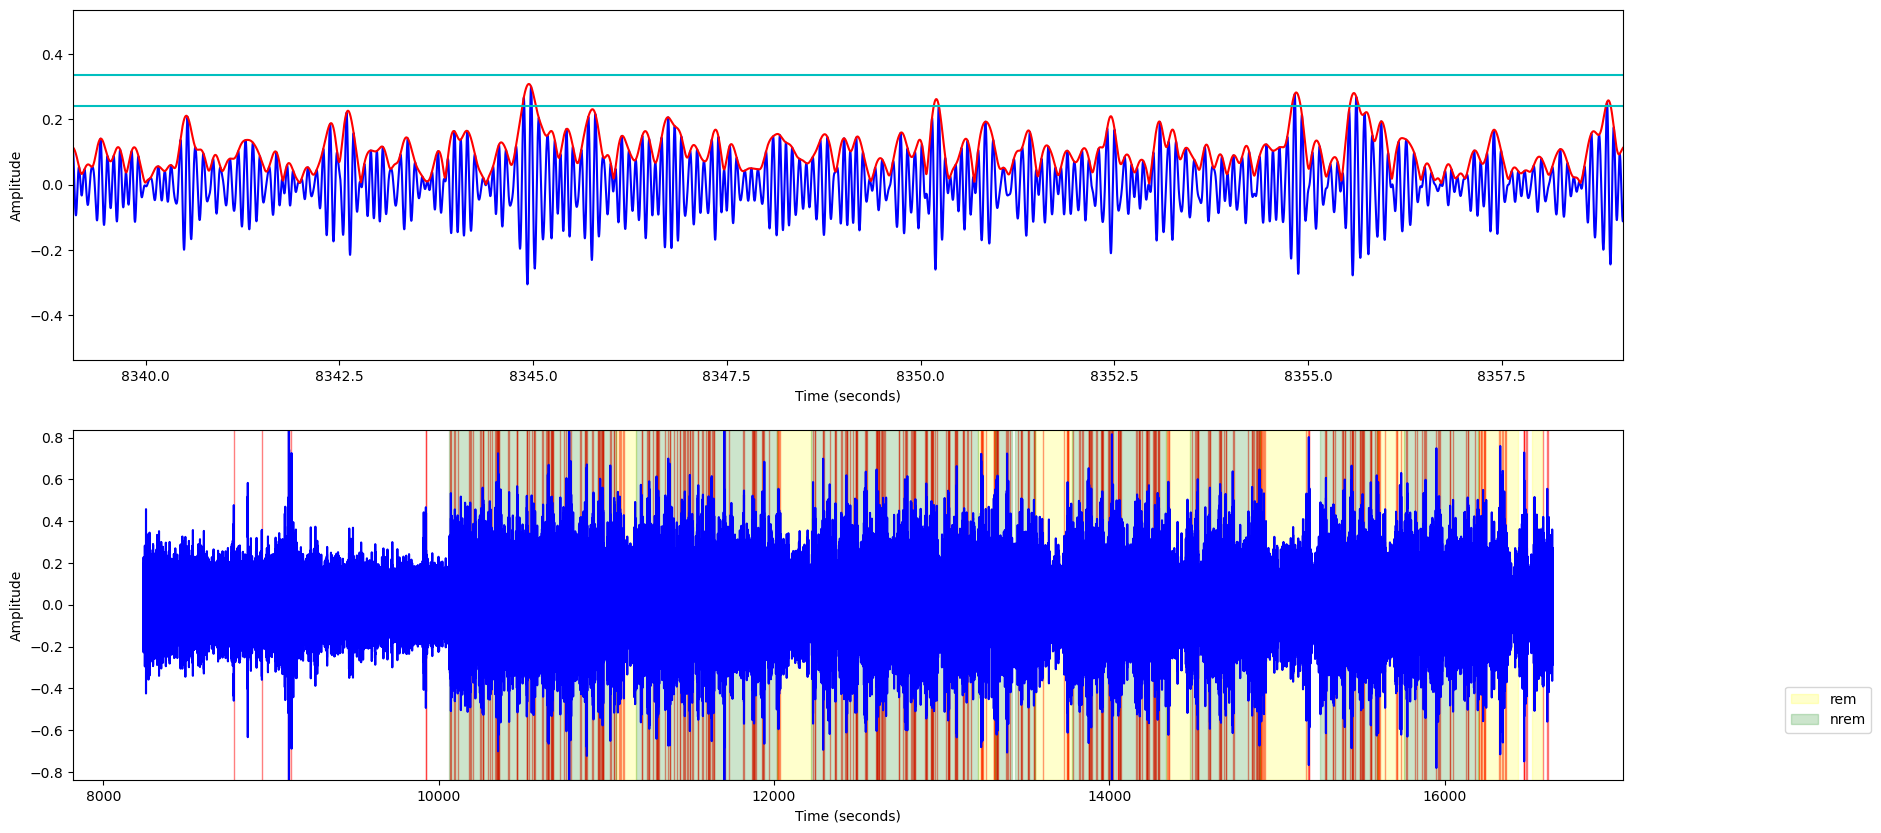

In [180]:
all_mice = ['seq006_1_1','seq006_1_3','seq006_1_4','seq006_1_5','seq006_1_6','seq006_1_8','seq006_1_9','seq006_1_10','seq006_1_11','seq007_1_1','seq007_1_2','seq007_1_3','seq007_1_4'
,'seq008_1_3','seq120_1_1','seq120_1_2','seq120_1_3','seq120_1_4','seq120_1_5','seq120_1_6','seq120_1_7','seq120_1_8']
ripples_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\hippocampus_lfp\processed_ripples\\"

all_mice = ['seq006_1_3']

for current_mouse in all_mice:
    print(current_mouse)
    for mouse_file in os.listdir(ripples_path):
        
        # 1 RIPPLES #####
        if mouse_file.split('.csv')[0] == current_mouse:
            # import ripples for mouse
            print('ripples found')
            ripples_df = pd.read_csv(ripples_path + mouse_file)
        # import spindle info
    
    ######### LOAD USEFUL STUFF
    nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data_bool = load_in_sleep_state_scoring(current_mouse)
    # load sync file
    behav_sync_file = load_sync_file(mouse_org_data_path,mouse)
    # get the ephys time from the sleep because this is what the lfp was trimmed down to.                        
    sleep_period_ephys_start_time = behav_sync_file.Camera_time_Ephys_Aligned[0]
    
    # 2 SPINDLES ######## check if spindles exist already 
    lfp_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\dual_hpc_str\\" + current_mouse 
    try:
        spindle_events = np.load(lfp_path + r'\analysis\spindle_events.npy')
        print('spind events already found')
    except:
        print('spindle events not found - processing...')
        # load spindle bandpassed data and find spindles...  
        spindle_bandpassed = np.load(lfp_path +r'\processed_data\zscored_spindle_bandpassed.npy')
        # SPINDLE IDENTIFICATION ##############################
        # find spindle events
        fs = 2500
        min_event_duration = 0.3 #s
        spindle_events,smoothed_envelope = filter_for_spindles_and_plot(spindle_bandpassed,nrem_start_ends,rem_start_ends,fs,min_event_duration,sleep_period_ephys_start_time)
        if not os.path.exists(lfp_path + r'\\analysis\\'):
            os.makedirs(lfp_path + r'\\analysis\\')
        plt.savefig(lfp_path + r'\\analysis\spindle_identification.png')

    # 3 REPLAY ########### import replay info for mouse
    replay_path = r'Z:\projects\sequence_squad\ppseq_finalised_publication_data\dual_str_hpc\striatum\postsleep\\' 
    
    replay_events_df,chunk_spans= load_in_replay_data(current_mouse,replay_path,nrem_start_ends,rem_start_ends)
    
    
    
    break


In [ ]:
# ripples per minute 
ripples_per_minute = (len(ripples_df.start_time.values) / max(ripples_df.start_time.values)) * 60
print(f"av ripple rate: {ripples_per_minute:.2f} per minute")

# event start times in seconds
times = ripples_df.start_time.values
# define sliding window
window = 60   # seconds per window
step = 10     # how much to slide each time (smaller = smoother curve)
# create window start positions
bins = np.arange(times.min(), times.max(), step)
# count how many ripples occur in each window
counts = np.array([
    np.sum((times >= b) & (times < b + window))
    for b in bins
])
# convert to rate per minute (since window = 60s, this is same as counts)
rates_per_minute = counts * (60 / window)
# find min & max
min_rate = rates_per_minute.min()
max_rate = rates_per_minute.max()
print(f"Lowest ripple rate: {min_rate:.2f} per minute")
print(f"Highest ripple rate: {max_rate:.2f} per minute")




av ripple rate: 31.52 per minute
Lowest ripple rate: 1.00 per minute
Highest ripple rate: 76.00 per minute


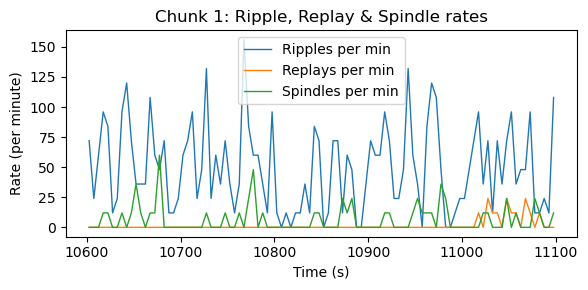

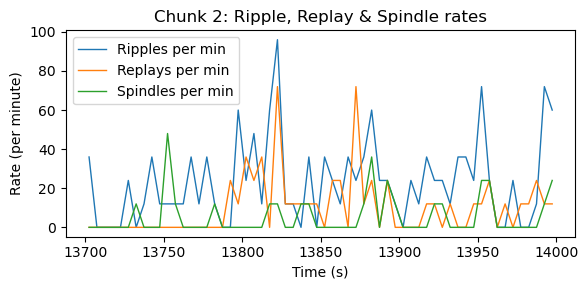

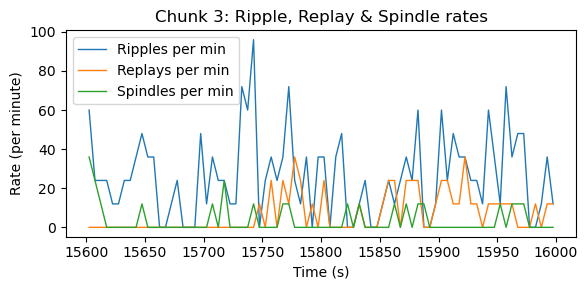

In [251]:
#### CORRELATION EXAMPLES
ripple_starts = ripples_df.start_time + sleep_period_ephys_start_time
replay_mids = replay_events_df.replay_abs_time
spindle_starts = [event['start_time'] for event in spindle_events]

# parameters
bin_size = 5  # seconds
chunk_ripple_counts = []
chunk_replay_counts = []
chunk_spindle_counts = []

for i, (chunk_start, chunk_end) in enumerate(chunk_spans):
    # define bins for this chunk
    bins = np.arange(chunk_start, chunk_end + bin_size, bin_size)
    bin_centers = bins[:-1] + bin_size / 2

    # count events per bin
    ripple_counts, _ = np.histogram(ripple_starts, bins=bins)
    replay_counts, _ = np.histogram(replay_mids, bins=bins)
    spindle_counts, _ = np.histogram(spindle_starts, bins=bins)
    
    chunk_ripple_counts += [ripple_counts]
    chunk_replay_counts += [replay_counts]
    chunk_spindle_counts += [spindle_counts]

    # convert counts → rates per minute
    ripple_rate = ripple_counts * (60 / bin_size)
    replay_rate = replay_counts * (60 / bin_size)
    spindle_rate = spindle_counts * (60 / bin_size)

    # --- plot ---
    plt.figure(figsize=(6, 3))
    plt.plot(bin_centers, ripple_rate, label="Ripples per min", lw=1)
    plt.plot(bin_centers, replay_rate, label="Replays per min", lw=1)
    plt.plot(bin_centers, spindle_rate, label="Spindles per min", lw=1)
    plt.title(f"Chunk {i+1}: Ripple, Replay & Spindle rates")
    plt.xlabel("Time (s)")
    plt.ylabel("Rate (per minute)")
    plt.legend()
    plt.tight_layout()
    plt.show()


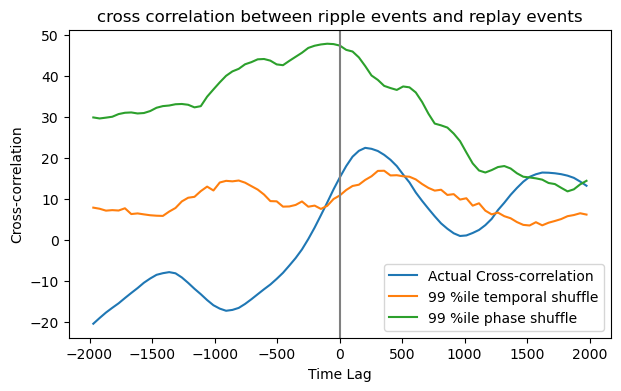

In [259]:

# bin the timeseries data
smoothing_window = 20
chunk_cross_corr_actual, chunk_temporal_shuffle,chunk_phase_shuffle = calculate_cross_correlation(chunk_ripple_counts,chunk_replay_counts, smoothing_window,num_shuffles=10)

# Plot the cross-correlation result
fig,ax= plt.subplots(1, 1,figsize=(7, 4))

data_length= 80 -1
bin_multiplier = 1/bin_size
time_lags = np.linspace(data_length*-1*bin_size/bin_multiplier+bin_size,data_length*bin_size/bin_multiplier,data_length)

ax.plot(time_lags, np.mean(chunk_cross_corr_actual,axis = 0), label='Actual Cross-correlation')
ax.plot(time_lags, np.mean(chunk_temporal_shuffle,axis = 0), label='99 %ile temporal shuffle')
ax.plot(time_lags, np.mean(chunk_phase_shuffle,axis = 0), label='99 %ile phase shuffle')
ax.axvline(0,color = 'grey')
ax.set_xlabel('Time Lag')
ax.set_ylabel('Cross-correlation')
ax.set_title(f'cross correlation between ripple events and replay events')
ax.legend()

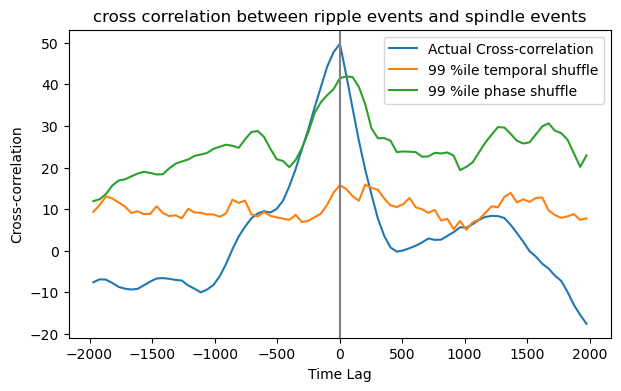

In [262]:

# bin the timeseries data
smoothing_window = 20
chunk_cross_corr_actual, chunk_temporal_shuffle,chunk_phase_shuffle = calculate_cross_correlation(chunk_ripple_counts,chunk_spindle_counts, smoothing_window,num_shuffles=10)

# Plot the cross-correlation result
fig,ax= plt.subplots(1, 1,figsize=(7, 4))

data_length= 80 -1
bin_multiplier = 1/bin_size
time_lags = np.linspace(data_length*-1*bin_size/bin_multiplier+bin_size,data_length*bin_size/bin_multiplier,data_length)

ax.plot(time_lags, np.mean(chunk_cross_corr_actual,axis = 0), label='Actual Cross-correlation')
ax.plot(time_lags, np.mean(chunk_temporal_shuffle,axis = 0), label='99 %ile temporal shuffle')
ax.plot(time_lags, np.mean(chunk_phase_shuffle,axis = 0), label='99 %ile phase shuffle')
ax.axvline(0,color = 'grey')
ax.set_xlabel('Time Lag')
ax.set_ylabel('Cross-correlation')
ax.set_title(f'cross correlation between ripple events and spindle events')
ax.legend()

In [ ]:
#### linkage analysis 
# replay count vs time lag to closest ripple
# percentage of relays that are linked to a ripple
# percentag of ripples linked to replay 

In [ ]:
# example ripple

# ripples per minute
# ripples and replay correlation
# ripples + spindles correlation 

# replay count vs time lag to closest ripple
# percentage of relays that are linked to a ripple
# percentag of ripples linked to replay 

# ripple power/length and replay/spindles

# event triggers ripple average?
# ripple linked features vs unlinked. 



# even if they dont correlate are ripples more likley druing replay epochs

In [100]:
os.listdir(dat_path)

['quick_view_output',
 'seq006_1_10_run_0808025_0701',
 'seq006_1_11_run_2905025_1007',
 'seq006_1_1_run_0907025_1800',
 'seq006_1_3_run_0908025_1017',
 'seq006_1_4_run_2805025_0013',
 'seq006_1_5_run_2505025_0247',
 'seq006_1_6_run_2905025_0946',
 'seq006_1_8_run_0908025_0601',
 'seq006_1_9_run_0908025_0756',
 'seq007_1_1_run_2605025_2356',
 'seq007_1_2_run_2905025_0509',
 'seq007_1_3_run_2905025_0930',
 'seq007_1_4_run_2405025_0900',
 'seq008_1_3_run_2005025_1712',
 'seq120_1_1_run_1010025_1548',
 'seq120_1_2_run_1010025_0814',
 'seq120_1_3_run_0810025_0313',
 'seq120_1_4_run_0710025_1505',
 'seq120_1_5_run_0810025_1041',
 'seq120_1_6_run_0810025_1718',
 'seq120_1_7_run_0810025_1634',
 'seq120_1_8_run_1010025_0355']

In [105]:
file = os.listdir(dat_path)[5]

'seq006_1_4'

In [113]:
mouse = current_mouse
dat_path = replay_path

print('---------------------')
print('searching for replay data')

pp_path = 'SKIP'
for file in os.listdir(dat_path):
    if mouse == file.split('_run')[0]:
        print(f'file found: \033[1m{file}\033[0m')
        pp_path = os.path.join(dat_path,file)

if pp_path == 'SKIP':
    print('skipped')
    # return None,'SKIP'
replay_data_path = pp_path + r'\_final_analysis_output\\'

params_file = pp_path + r'\trainingData\\' + 'params_' + mouse + '.json'
with open(params_file, 'r') as file:
    params = json.load(file)
time_spans = params['time_span']

replay_events_df = pd.DataFrame({})
start_offset = []
for file in os.listdir(replay_data_path):
    if 'chunk' in file:
        print(file)

        chunk_number = int(file.split('_')[0][-1])

        start_offs = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
        start_offset +=[start_offs]


        print(replay_data_path)

        df_load = pd.read_csv(replay_data_path + file + r'\filtered_replay_clusters_df.csv',index_col=0)
        df_load['chunk'] = [chunk_number]*len(df_load)
        
        df_load['chunk_time'] = [time_spans[chunk_number-1]]*len(df_load)
        fs_times_ephys_time = (df_load.first_spike_time.values - start_offs)
        df_load['first_spike_ephys_time'] = fs_times_ephys_time
        df_load["replay_abs_time"] = df_load['chunk_time'].values[0][0] + df_load["first_spike_ephys_time"] + df_load["event_length"]/2
        replay_events_df = pd.concat((replay_events_df,df_load),axis =0)
        replay_events_df.reset_index(drop = True)

        print (f"\033[1mSuccess!\033[0m Loaded replay data files for mouse: {mouse}.")
        print('---------------------')

---------------------
searching for replay data
file found: seq006_1_1_run_0907025_1800


In [115]:
os.listdir(replay_data_path)

['filtering_curve.png', 'log_l_curve.png', 'state_rates_df.csv']